## Killariben Limbachiya

# Classical NLP Approach - Sentiment Analysis

# Load cleaned & merged dataset

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset that has transcripts + economic indicators
df_merged = pd.read_csv('/content/drive/My Drive/NLP/Assignment_3/merged_fomc_with_indicators.csv')
print("✅ Dataset loaded.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded.


# NLP + Quality Analysis before Cleaning

In [ ]:
# --- 3. Noise + Quality Metric Analysis (Pre-cleaning) ---
import numpy as np
import string
from wordcloud import STOPWORDS
import plotly.graph_objs as go
import spacy  # Import spaCy

# Load the spaCy model (you might need to download it first)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

# Metric functions
def calc_snr_ratio(text):
    words = text.split()
    return len(set(words)) / (len(words) + 1e-5) if words else 0

def calc_stopword_ratio(text):
    words = text.split()
    return sum(1 for w in words if w.lower() in STOPWORDS) / len(words) if words else 0

def calc_redundancy_ratio(text):
    words = text.split()
    return 1 - (len(set(words)) / len(words)) if words else 0

def calc_special_char_density(text):
    return sum(1 for c in text if c in string.punctuation) / (len(text) + 1e-5)

def calc_semantic_density(text):
    doc = nlp(text)
    return sum(1 for t in doc if t.pos_ in ['NOUN', 'VERB', 'ADJ']) / len(doc) if len(doc) > 0 else 0

def calc_digit_ratio(text):
    return sum(1 for c in text if c.isdigit()) / (len(text) + 1e-5)

def calc_noise_score(row):
    return row['StopWord_Ratio'] + row['Digit_Ratio'] + row['SpecialChar_Density']

def calc_quality_score(row):
    return row['SNR_Ratio'] + row['Semantic_Density'] - row['Noise_Score']

# Apply metrics on raw Content
df_merged['SNR_Ratio'] = df_merged['Content'].apply(calc_snr_ratio)
df_merged['StopWord_Ratio'] = df_merged['Content'].apply(calc_stopword_ratio)
df_merged['Redundancy_Ratio'] = df_merged['Content'].apply(calc_redundancy_ratio)
df_merged['SpecialChar_Density'] = df_merged['Content'].apply(calc_special_char_density)
df_merged['Semantic_Density'] = df_merged['Content'].apply(calc_semantic_density)
df_merged['Digit_Ratio'] = df_merged['Content'].apply(calc_digit_ratio)
df_merged['Noise_Score'] = df_merged.apply(calc_noise_score, axis=1)
df_merged['Quality_Score'] = df_merged.apply(calc_quality_score, axis=1)

# Plot each metric individually
metric_colors = {
    'SNR_Ratio': 'blue',
    'StopWord_Ratio': 'red',
    'Redundancy_Ratio': 'green',
    'SpecialChar_Density': 'purple',
    'Semantic_Density': 'orange',
    'Digit_Ratio': 'brown',
    'Noise_Score': 'teal',
    'Quality_Score': 'maroon'
}

for metric, color in metric_colors.items():
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_merged['Date'],
        y=df_merged[metric],
        mode='lines+markers+text',
        text=["Low" if v < 0.25 else "Medium" if v < 0.5 else "High" for v in df_merged[metric]],
        textposition="top center",
        marker=dict(color=color),
        name=metric
    ))
    fig.update_layout(
        title=f"{metric.replace('_', ' ')} Over Time (Labeled)",
        xaxis_title='Date',
        yaxis_title=metric.replace('_', ' '),
        height=500,
        width=1100
    )
    fig.show()

In [ ]:
import os
import spacy
from bs4 import BeautifulSoup
import re
import string

In [ ]:
# Cleaning pipeline
try:
    nlp = spacy.load("en_core_web_sm")
except:
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def minimal_clean(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)         # Remove emails
    text = re.sub(r'\s+', ' ', text).strip()    # Normalize whitespace
    return text

df_merged['cleaned_text'] = df_merged['Content'].fillna('').apply(minimal_clean)
print("✅ Texts cleaned.")

✅ Texts cleaned.


In [ ]:
# Save checkpoint
output_path_cleaned = "/content/drive/My Drive/NLP/Assignment_3/fomc_transcripts_spacy_cleaned.csv"
df_merged.to_csv(output_path_cleaned, index=False)
print(f"\n✅ Cleaned data saved to {output_path_cleaned}")


✅ Cleaned data saved to /content/drive/My Drive/NLP/Assignment_3/fomc_transcripts_spacy_cleaned.csv


# NLP + Quality Analysis after Cleaning

In [ ]:
# --- 4. Noise Metrics After Cleaning ---
df_merged['SNR_Ratio_Cleaned'] = df_merged['cleaned_text'].apply(calc_snr_ratio)
df_merged['StopWord_Ratio_Cleaned'] = df_merged['cleaned_text'].apply(calc_stopword_ratio)
df_merged['Redundancy_Ratio_Cleaned'] = df_merged['cleaned_text'].apply(calc_redundancy_ratio)
df_merged['SpecialChar_Density_Cleaned'] = df_merged['cleaned_text'].apply(calc_special_char_density)
df_merged['Semantic_Density_Cleaned'] = df_merged['cleaned_text'].apply(calc_semantic_density)
df_merged['Digit_Ratio_Cleaned'] = df_merged['cleaned_text'].apply(calc_digit_ratio)
df_merged['Noise_Score_Cleaned'] = df_merged.apply(lambda row: row['StopWord_Ratio_Cleaned'] + row['Digit_Ratio_Cleaned'] + row['SpecialChar_Density_Cleaned'], axis=1)
df_merged['Quality_Score_Cleaned'] = df_merged.apply(lambda row: row['SNR_Ratio_Cleaned'] + row['Semantic_Density_Cleaned'] - row['Noise_Score_Cleaned'], axis=1)

# Plot each metric individually (After Cleaning)
for metric, color in metric_colors.items():
    metric_clean = metric + '_Cleaned'
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_merged['Date'],
        y=df_merged[metric_clean],
        mode='lines+markers+text',
        text=["Low" if v < 0.25 else "Medium" if v < 0.5 else "High" for v in df_merged[metric_clean]],
        textposition="top center",
        marker=dict(color=color),
        name=metric_clean
    ))
    fig.update_layout(
        title=f"{metric.replace('_', ' ')} Over Time (After Cleaning)",
        xaxis_title='Date',
        yaxis_title=metric.replace('_', ' '),
        height=500,
        width=1100
    )
    fig.show()

# VADER Sentiment Analysis on FOMC Transcripts

Used the vaderSentiment library to calculate:

    pos: positive score

    neg: negative score

    neu: neutral score

    compound: overall sentiment score

In [ ]:
# Load Cleaned dataset
df_merged = pd.read_csv('/content/drive/My Drive/NLP/Assignment_3/fomc_transcripts_spacy_cleaned.csv')
print("✅Cleaned Dataset loaded.")

✅Cleaned Dataset loaded.


In [ ]:
!pip install vaderSentiment

In [ ]:
df_merged['cleaned_text'].str.len().describe()


,cleaned_text
count,66.000000
mean,57459.045455
std,12437.504895
min,44054.000000
25%,49508.500000
50%,54478.500000
75%,58313.750000
max,94634.000000


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER
nltk.download('vader_lexicon')

# Initialize Analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER
df_merged[['neg', 'neu', 'pos', 'compound']] = df_merged['cleaned_text'].apply(lambda x: pd.Series(analyzer.polarity_scores(x)))

print("✅ VADER Sentiment Scores Extracted!")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


✅ VADER Sentiment Scores Extracted!


In [ ]:
analyzer.polarity_scores(df_merged['cleaned_text'].iloc[0])

{'neg': 0.055, 'neu': 0.849, 'pos': 0.095, 'compound': 0.9998}

In [ ]:
df_merged['cleaned_text'].iloc[0][:1000]


"HomeMonetary PolicyFederal Open Market CommitteeFederal Open Market CommitteePDFPlease enable JavaScript if it is disabled in your browser or access the information through the links provided below.FOMC MinutesMinutes of the Federal Open Market CommitteeMarch 18â\x80\x9319, 2025A joint meeting of the Federal Open Market Committee and the Board of Governors of the Federal Reserve System was held in the offices of the Board of Governors on Tuesday, March 18, 2025, at 9:00 a.m. and continued on Wednesday, March 19, 2025, at 9:00 a.m.1Review of Monetary Policy Strategy, Tools, and CommunicationsCommittee participants continued their discussions related to their review of the Federal Reserve's monetary policy framework, with a focus on labor market dynamics and the FOMC's maximum employment goal. The staff briefed policymakers on the concept of maximum employment and related labor market indicators. They discussed conceptual benchmarks used in evaluating the position of the labor market re

In [ ]:
# --- Distribution of Compound Scores ---
import plotly.express as px

# Plot distribution of compound scores
fig = px.histogram(df_merged, x='compound', nbins=20, title='Distribution of Compound Sentiment Scores')
fig.update_layout(height=400, width=1000)
fig.show()

# 📊 Plot Sentiment Trends Over Time

In [ ]:
# Convert the date column and group by year or month
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
df_merged['Year'] = df_merged['Date'].dt.year
df_merged['Month'] = df_merged['Date'].dt.to_period('M').dt.to_timestamp()

# Group by month for trend overview
sentiment_by_year = df_merged.groupby('Year')[['compound', 'pos', 'neu', 'neg']].mean()

## **Plot the trends**

<ipython-input-102-a3b5480ee5c1>:8: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



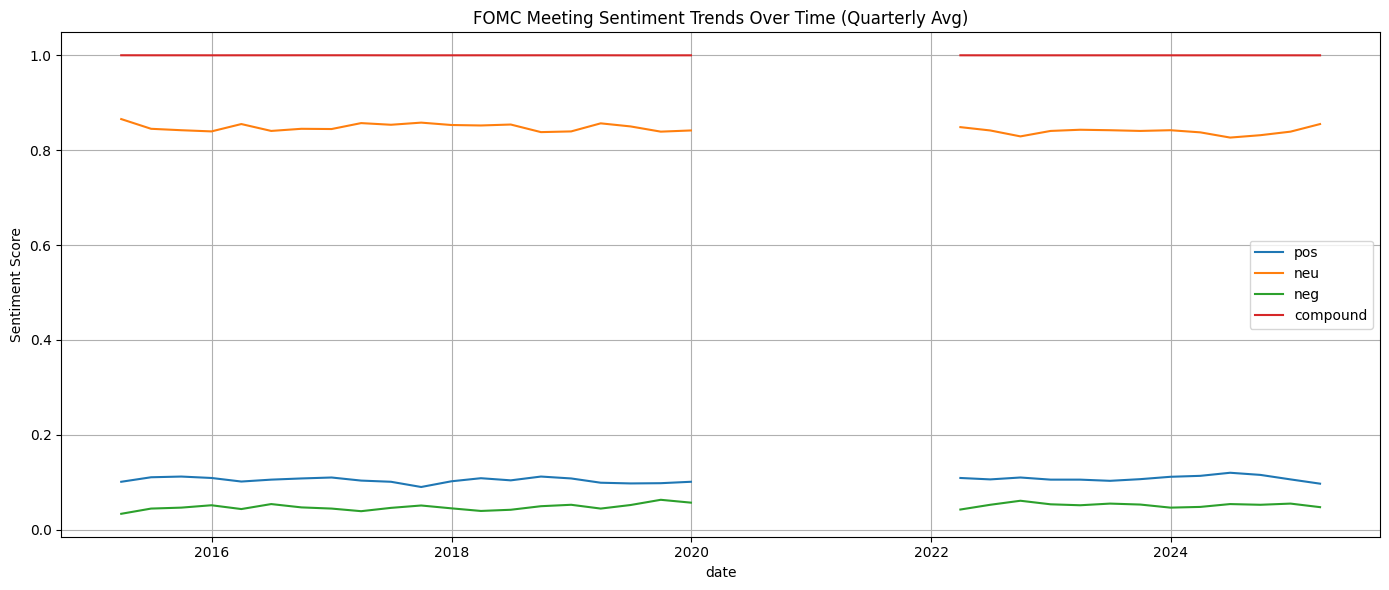

In [ ]:
import matplotlib.pyplot as plt

# Set datetime index
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged.sort_values('date', inplace=True)

# Rolling sentiment (quarterly average)
sentiment_trend = df_merged.set_index('date').resample('Q')[['pos', 'neu', 'neg', 'compound']].mean()

# Plot sentiment over time
plt.figure(figsize=(14, 6))
for col in ['pos', 'neu', 'neg', 'compound']:
    plt.plot(sentiment_trend.index, sentiment_trend[col], label=col)

plt.title("FOMC Meeting Sentiment Trends Over Time (Quarterly Avg)")
plt.xlabel("date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


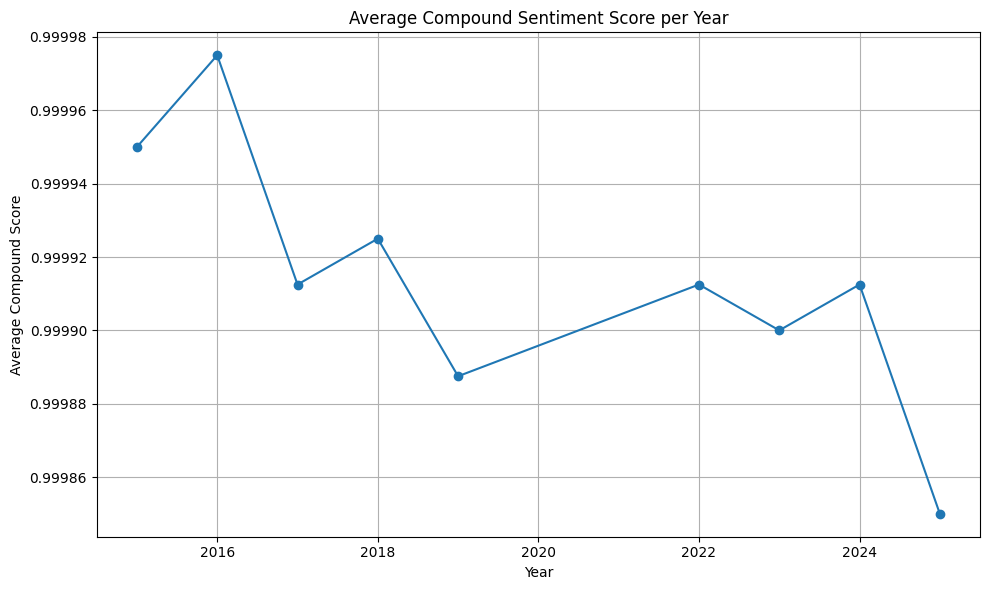

In [ ]:
import matplotlib.pyplot as plt

# Group by year and compute average compound sentiment score
avg_compound_by_year = df_merged.groupby('Year')['compound'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(avg_compound_by_year.index, avg_compound_by_year.values, marker='o', linestyle='-')
plt.title('Average Compound Sentiment Score per Year')
plt.xlabel('Year')
plt.ylabel('Average Compound Score')
plt.grid(True)
plt.tight_layout()
plt.show()


Wordclouds

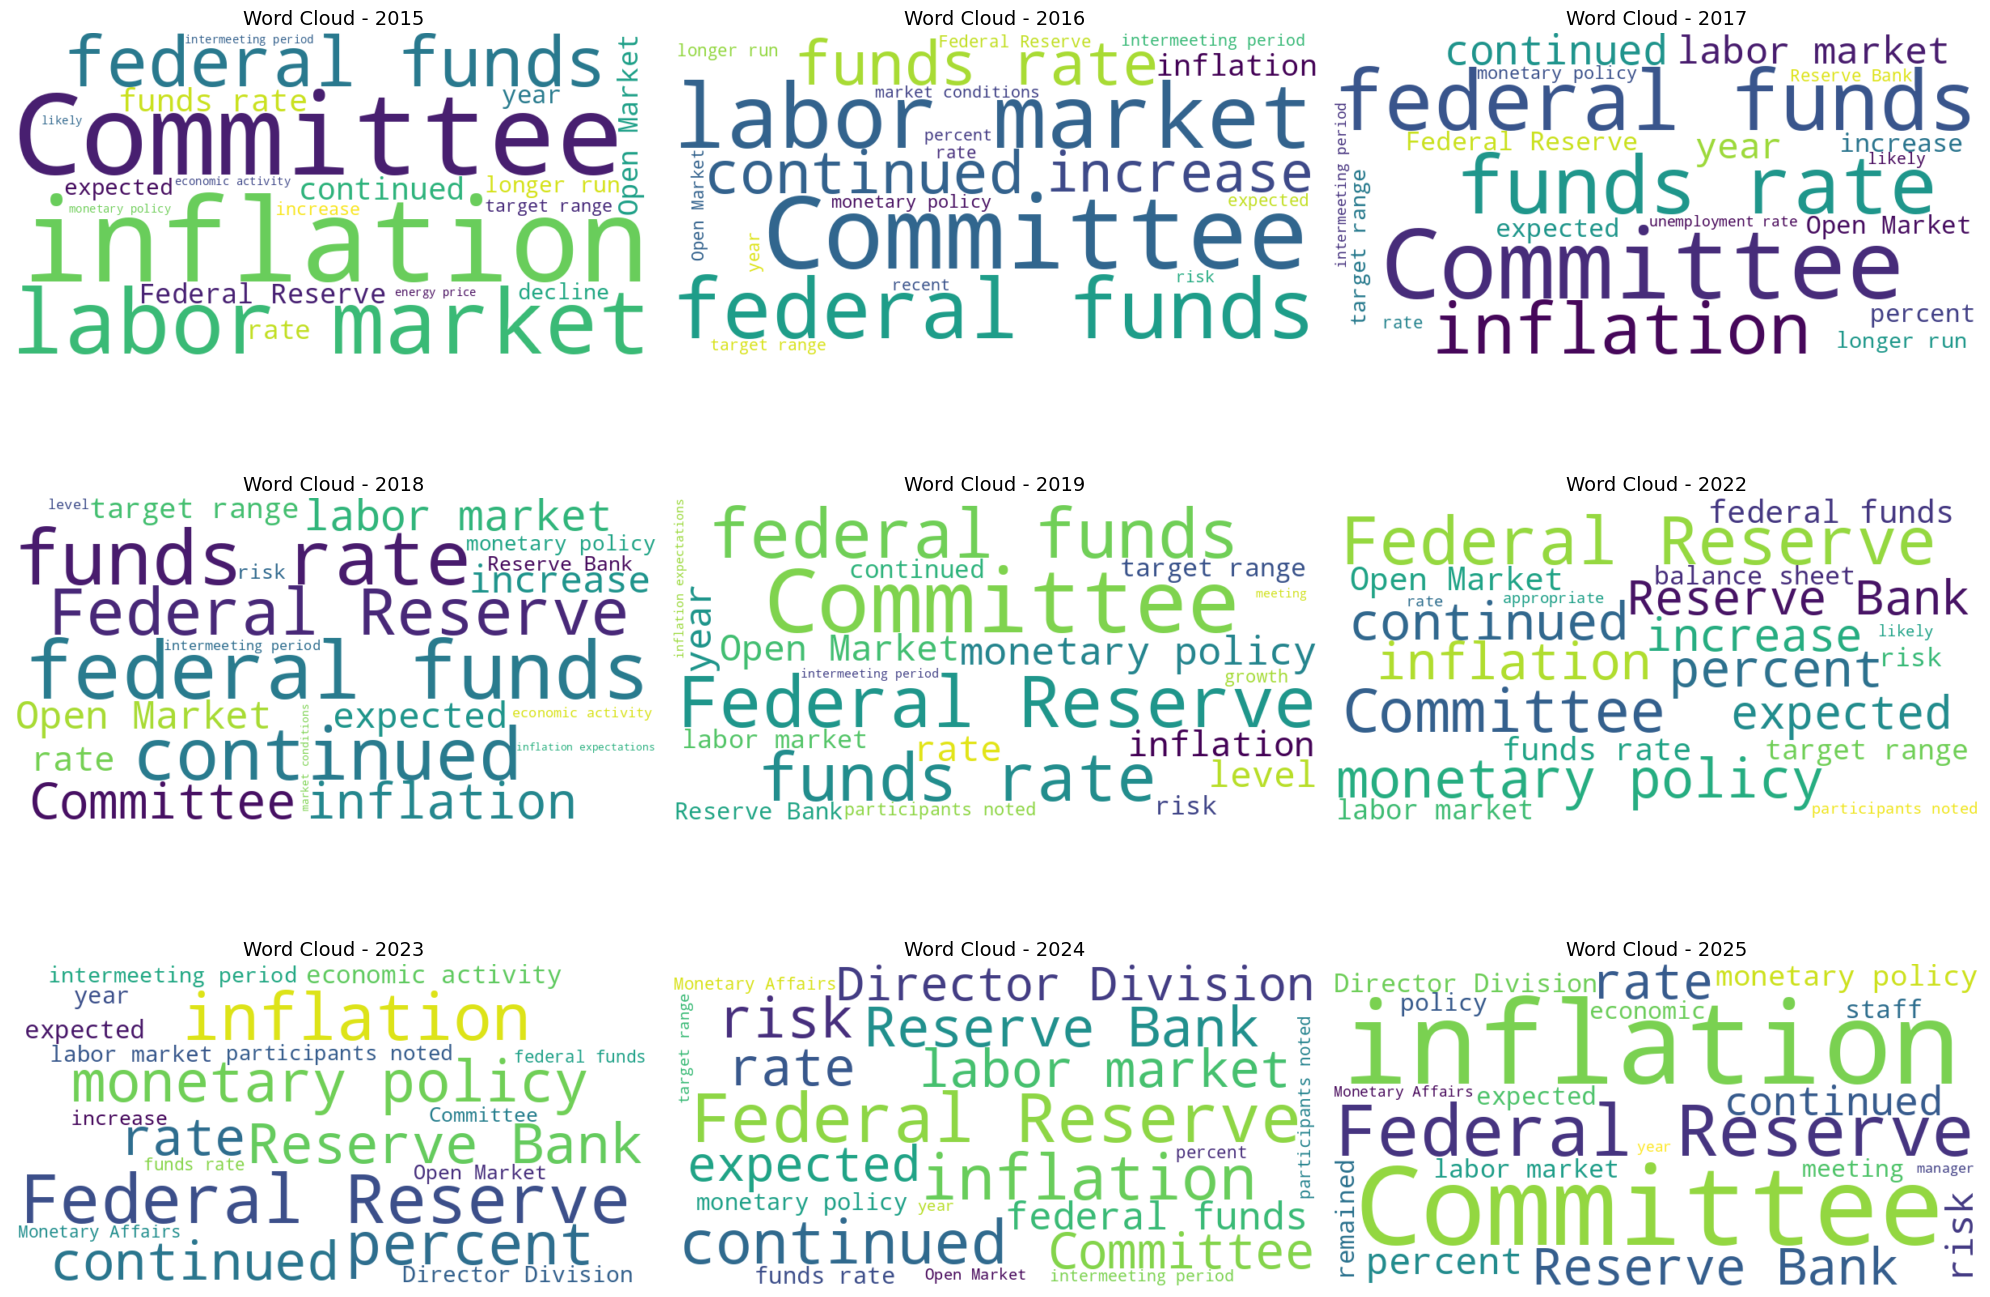

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Make sure you load the cleaned data that contains the 'cleaned_text' column
df_merged = pd.read_csv('/content/drive/My Drive/NLP/Assignment_3/fomc_transcripts_spacy_cleaned.csv')

# Generate word clouds for each year
years = sorted(df_merged['Year'].dropna().unique())
ncols = 3
nrows = (len(years) + ncols - 1) // ncols

plt.figure(figsize=(20, 5 * nrows))

for i, year in enumerate(years):
    # Use 'cleaned_text' column instead of 'cleaned_content'
    year_text = ' '.join(df_merged[df_merged['Year'] == year]['cleaned_text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(year_text)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {year}', fontsize=14)

plt.tight_layout()
plt.show()

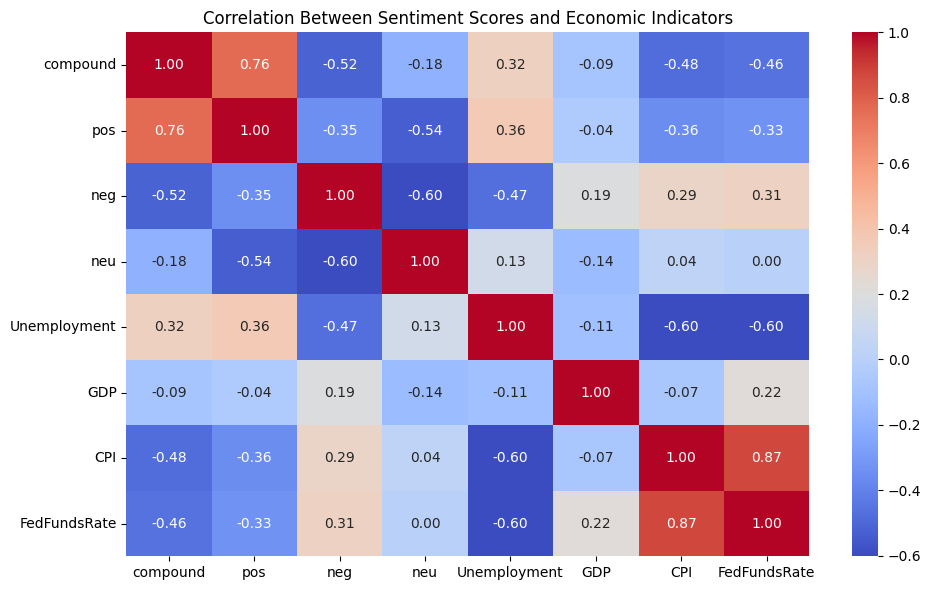

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataframe with sentiment scores
df_merged = pd.read_csv('/content/drive/My Drive/NLP/Assignment_3/fomc_with_sentiment.csv')

# Select relevant columns
correlation_df = df_merged[['compound', 'pos', 'neg', 'neu', 'Unemployment', 'GDP', 'CPI', 'FedFundsRate']]

# Drop any rows with NaNs
correlation_df = correlation_df.dropna()

# Compute correlation
corr = correlation_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Sentiment Scores and Economic Indicators")
plt.tight_layout()
plt.show()

Analyze changes in
sentiment vocabulary over time

In [ ]:
from collections import Counter

# Dictionary to hold word frequencies per year
yearly_word_freq = {}

# Collect top words per year
for year in sorted(df_merged['Year'].dropna().unique()):
    texts = df_merged[df_merged['Year'] == year]['cleaned_text'].dropna().tolist()
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    yearly_word_freq[year] = word_counts

# Aggregate across all years
total_word_counts = Counter()
for year_counts in yearly_word_freq.values():
    total_word_counts += year_counts

# Get top N words overall
top_words = [word for word, _ in total_word_counts.most_common(15)]
print("Top sentiment-related words:", top_words)

# Build a DataFrame with frequency of top words over years
word_trends = pd.DataFrame(index=sorted(yearly_word_freq.keys()), columns=top_words).fillna(0)

for year, counts in yearly_word_freq.items():
    for word in top_words:
        word_trends.loc[year, word] = counts.get(word, 0)

# Normalize by total words per year (optional)
word_trends = word_trends.div(word_trends.sum(axis=1), axis=0)


Top sentiment-related words: ['the', 'of', 'in', 'and', 'to', 'that', 'a', 'for', 'on', 'inflation', 'as', 'was', 'rate', 'at', 'participants']


<ipython-input-106-f2e7672f4659>:23: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



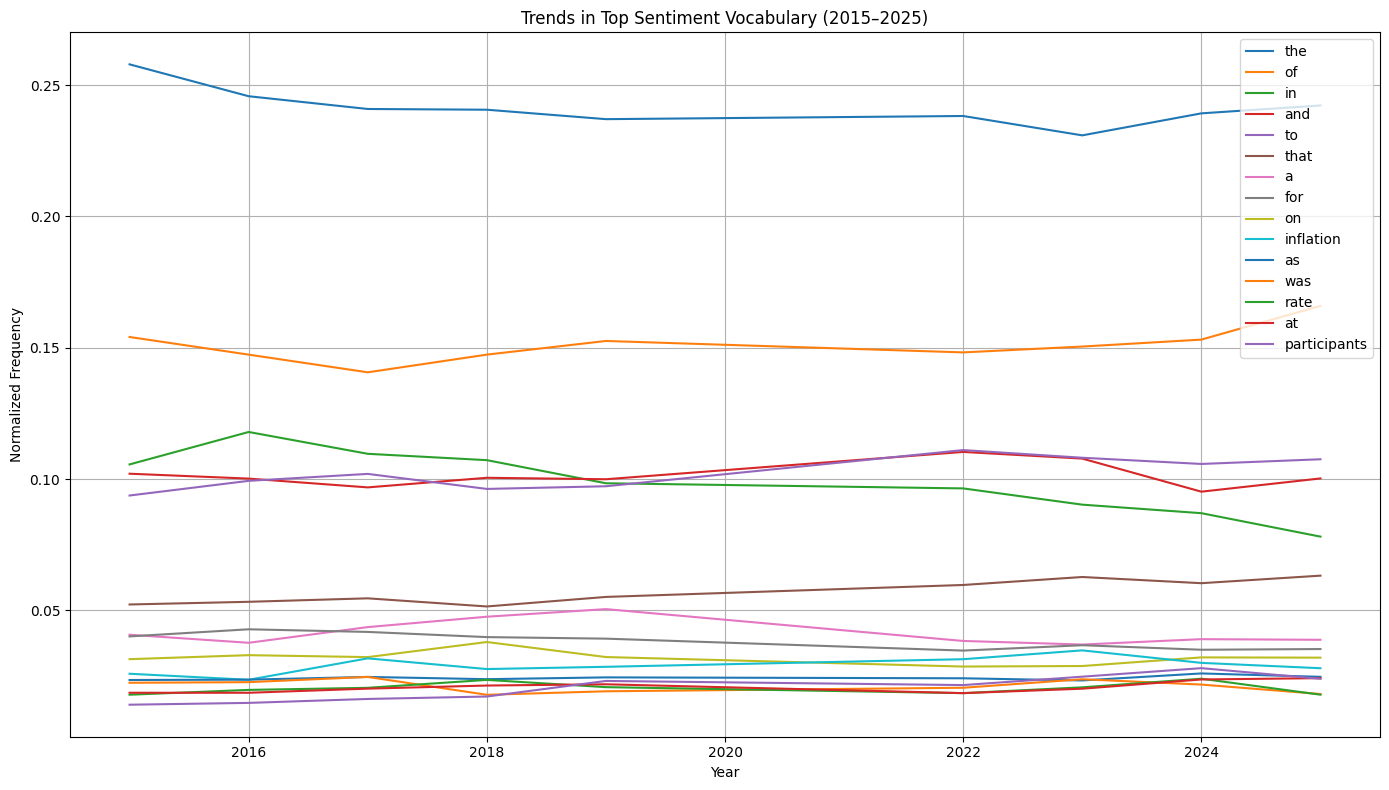

In [ ]:
plt.figure(figsize=(14, 8))
for word in top_words:
    plt.plot(word_trends.index, word_trends[word], label=word)

plt.title('Trends in Top Sentiment Vocabulary (2015–2025)')
plt.xlabel('Year')
plt.ylabel('Normalized Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- 7. Sentiment by Quarter ---
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

df_merged['Quarter'] = df_merged['Date'].dt.to_period('Q').astype(str)
sentiment_by_quarter = df_merged.groupby('Quarter')[['pos', 'neg', 'neu', 'compound']].mean().reset_index()
fig = px.line(sentiment_by_quarter, x='Quarter', y='compound', markers=True, title='Compound Sentiment by Quarter')
fig.update_layout(height=500, width=1100)
fig.show()

In [ ]:
# --- 9. Word Frequency (Top Words Overall) ---
from collections import Counter
import plotly.graph_objs as go

all_words = ' '.join(df_merged['cleaned_text'].fillna('')).split()
word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

words, counts = zip(*top_words)
fig = go.Figure([go.Bar(x=words, y=counts)])
fig.update_layout(title='Top 20 Words in Cleaned Text', xaxis_title='Word', yaxis_title='Frequency', height=500, width=1100)
fig.show()

# --- Save final dataset ---
final_output_path = "/content/fomc_transcripts_with_sentiment.csv"
df_merged.to_csv(final_output_path, index=False)
print(f"\n✅ Final dataset with sentiment and plots saved to {final_output_path}")



✅ Final dataset with sentiment and plots saved to /content/fomc_transcripts_with_sentiment.csv


# Classical NLP Approach - Topic Modeling

Clean and Tokenize text

In [ ]:
# --- 1. Clean & Tokenize ---
import re
import pandas as pd
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

# Load spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_merged['cleaned_content'] = df_merged['Content'].fillna('').apply(clean_text)

# Tokenize and remove stopwords
def tokenize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

df_merged['Tokens'] = df_merged['cleaned_content'].apply(tokenize)
print("✅ Text cleaned and tokenized.")

✅ Text cleaned and tokenized.


Coherence Score Optimization

In [ ]:
def find_optimal_topics_gensim(df_tokens, max_topics=12):
    dictionary = Dictionary(df_tokens)
    corpus = [dictionary.doc2bow(text) for text in df_tokens]

    coherence_scores = {}
    for k in range(2, max_topics + 1):
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=42)
        cm = CoherenceModel(model=lda_model, texts=df_tokens, dictionary=dictionary, coherence='c_v')
        coherence_scores[k] = cm.get_coherence()
        print(f"Topics: {k}, Coherence Score: {coherence_scores[k]:.4f}")

    # Plot scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(list(coherence_scores.keys()), list(coherence_scores.values()), marker='o')
    plt.title("Coherence Score by Number of Topics")
    plt.xlabel("Num Topics"); plt.ylabel("Coherence Score")
    plt.grid(True)
    plt.show()

    best_k = max(coherence_scores, key=coherence_scores.get)
    return best_k, dictionary, corpus


Run this to find best k

Topics: 2, Coherence Score: 0.3497


Topics: 3, Coherence Score: 0.3394


Topics: 4, Coherence Score: 0.3478


Topics: 5, Coherence Score: 0.3622


Topics: 6, Coherence Score: 0.3574


Topics: 7, Coherence Score: 0.3474


Topics: 8, Coherence Score: 0.3534


Topics: 9, Coherence Score: 0.3484


Topics: 10, Coherence Score: 0.3504


Topics: 11, Coherence Score: 0.3503
Topics: 12, Coherence Score: 0.3496


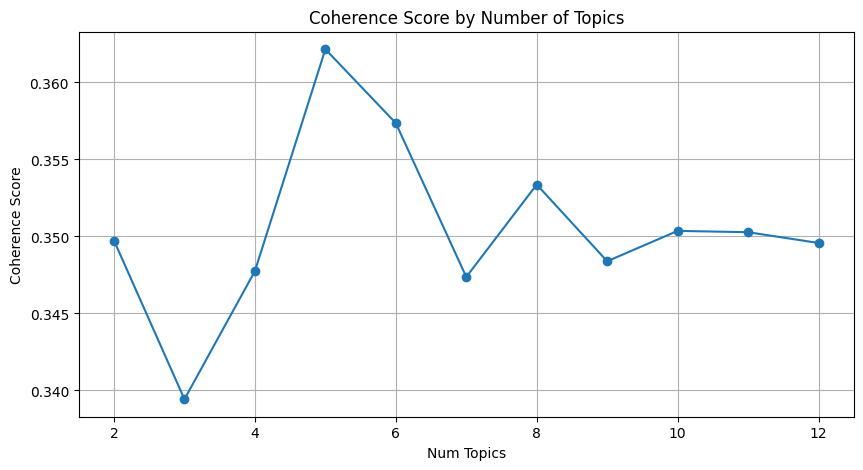

In [ ]:
best_k, dictionary, corpus = find_optimal_topics_gensim(df_merged['Tokens'])


Train Final LDA Model using (gensim)

In [ ]:
from gensim.models import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_k,
    random_state=42,
    passes=10,          # full corpus iterations
    iterations=100      # per-document iterations
)

print(f"✅ Final LDA model with {best_k} topics trained.")

✅ Final LDA model with 5 topics trained.


Re-evaluate Coherence Score After Training

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

# Evaluate the model using coherence score
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=df_merged['Tokens'],
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model_lda.get_coherence()
print(f"📈 Coherence Score (after passes): {coherence_score:.4f}")


📈 Coherence Score (after passes): 0.3559


Save the Trained Model

In [ ]:
lda_model.save("/content/drive/My Drive/NLP/Assignment_3/final_lda_model.gensim")
dictionary.save("/content/drive/My Drive/NLP/Assignment_3/final_dictionary.dict")
print("✅ Final LDA model and dictionary saved.")

✅ Final LDA model and dictionary saved.


And to reload:

In [ ]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

lda_model = LdaModel.load("/content/drive/My Drive/NLP/Assignment_3/final_lda_model.gensim")
dictionary = Dictionary.load("/content/drive/My Drive/NLP/Assignment_3/final_dictionary.dict")
print("✅ Final LDA model and dictionary loaded.")

✅ Final LDA model and dictionary loaded.


Assign Topics to Each Document

In [ ]:
def assign_gensim_topics(df, corpus, lda_model):
    dominant_topics = []
    topic_keywords = {}

    for bow in corpus:
        topic_probs = lda_model.get_document_topics(bow, minimum_probability=0.0)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)

    for topic_num in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_num, topn=5)
        topic_keywords[topic_num] = " / ".join([w for w, _ in words])

    df['topics'] = [f"Topic {i}: {topic_keywords[i]}" for i in dominant_topics]
    return df, topic_keywords


In [ ]:
df_merged, topic_map = assign_gensim_topics(df_merged, corpus, lda_model)


📊 Visualize Topic Distribution

<ipython-input-119-5531f6baec09>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




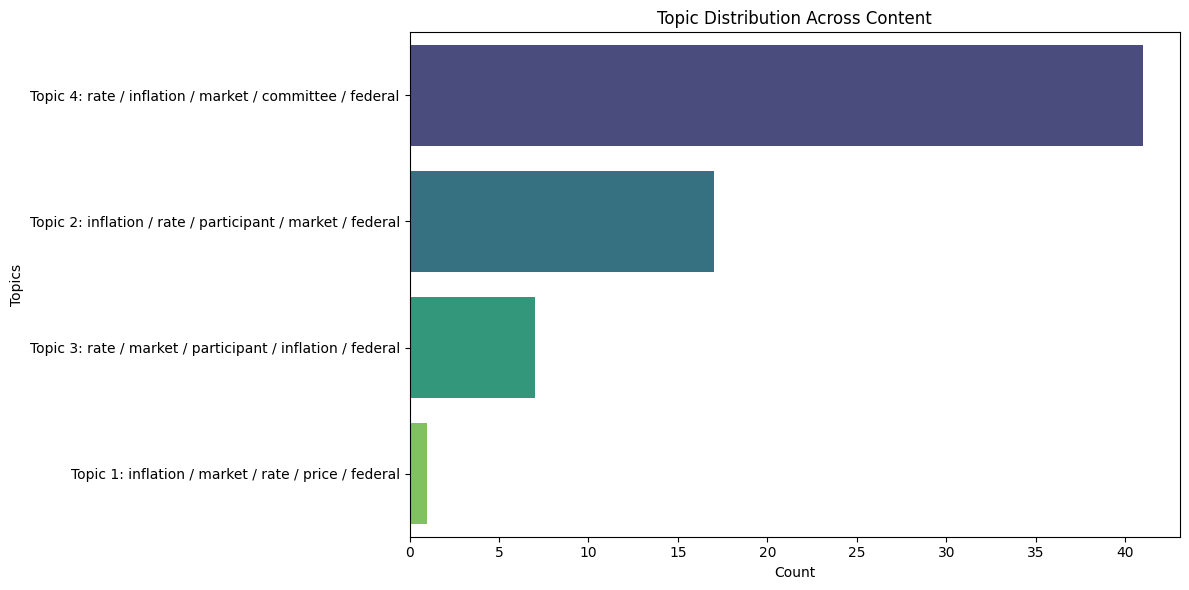

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_topic_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(y=df['topics'], order=df['topics'].value_counts().index, palette="viridis")
    plt.title("Topic Distribution Across Content")
    plt.xlabel("Count"); plt.ylabel("Topics")
    plt.tight_layout()
    plt.show()

plot_topic_distribution(df_merged)


# Topic Trend Over Time (by Year)

In [ ]:
# Make sure 'Date' is datetime and 'Year' column exists
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
df_merged['Year'] = df_merged['Date'].dt.year

# Count topic occurrences per year
topic_year_dist = df_merged.groupby(['Year', 'topics']).size().reset_index(name='Count')

# Pivot the data for stacked bar plot
topic_year_pivot = topic_year_dist.pivot(index='Year', columns='topics', values='Count').fillna(0)

# Plot using plotly
import plotly.express as px

fig = px.bar(topic_year_pivot,
             x=topic_year_pivot.index,
             y=topic_year_pivot.columns,
             title="Topic Distribution Over Years",
             labels={'value': 'Count', 'Year': 'Year'},
             height=500)

fig.update_layout(barmode='stack', xaxis_title="Year", yaxis_title="Document Count")
fig.show()


# Word Cloud Per Topic

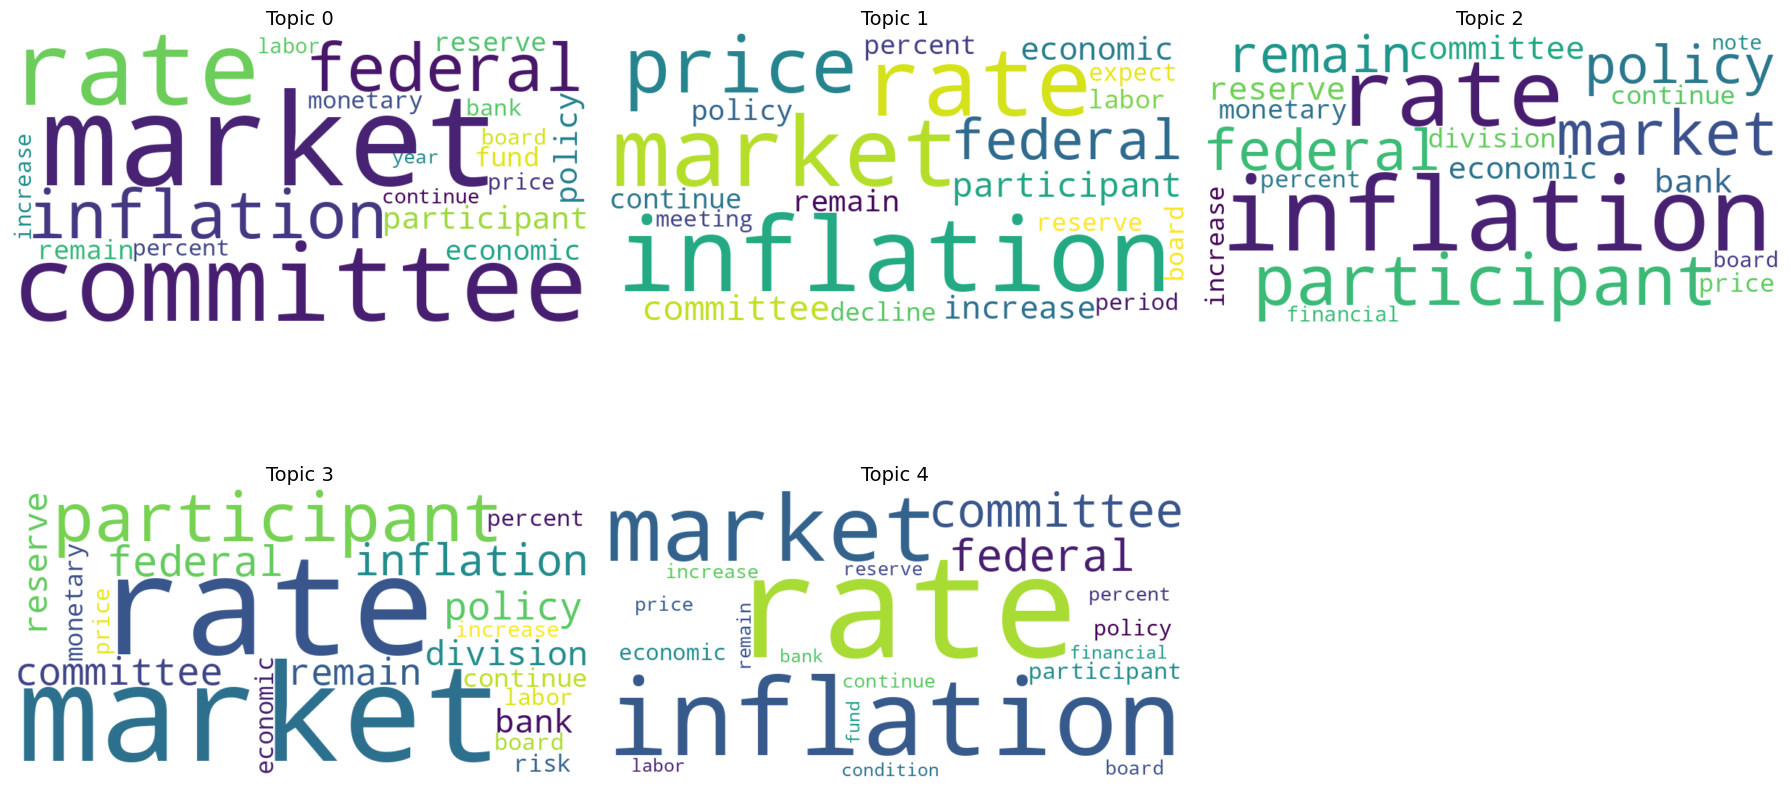

In [ ]:
from wordcloud import WordCloud

def generate_wordclouds_for_topics(lda_model, num_words=20):
    cols = 3
    rows = int(np.ceil(lda_model.num_topics / cols))
    plt.figure(figsize=(6 * cols, 5 * rows))

    for topic_id in range(lda_model.num_topics):
        plt.subplot(rows, cols, topic_id + 1)
        topic_terms = lda_model.show_topic(topic_id, topn=num_words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(topic_terms))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_id}", fontsize=14)

    plt.tight_layout()
    plt.show()

generate_wordclouds_for_topics(lda_model)


## **Interactive pyLDAvis**

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis  # This will open the interactive panel inside the notebook


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.070148  0.043017       1        1  63.639330
2      0.082561 -0.022030       2        1  23.813913
3      0.051158 -0.044471       3        1   8.788359
1      0.006400  0.027757       4        1   3.754387
0     -0.210267 -0.004274       5        1   0.004012, topic_info=             Term         Freq        Total Category  logprob  loglift
949        market  4699.000000  4699.000000  Default  30.0000  30.0000
787     inflation  5095.000000  5095.000000  Default  29.0000  29.0000
1264         rate  5075.000000  5075.000000  Default  28.0000  28.0000
1117  participant  3876.000000  3876.000000  Default  27.0000  27.0000
276     committee  3955.000000  3955.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
972       meeting     0.010233  1284.070443   Topic5  -7.1655  -1.6162
107   appropriate     0.008902   821.592750   Topic5  -7.3048  -1.3090
337      continue     0.012255  2507.416479   Topic5  -6.9852  -2.1051
926           low     0.010045  1332.017788   Topic5  -7.1840  -1.6714
306     condition     0.010957  1797.031226   Topic5  -7.0971  -1.8840

[451 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
7         1  0.983151         accommodate
7         4  0.021848         accommodate
8         1  0.908189       accommodation
8         2  0.010685       accommodation
8         3  0.005342       accommodation
...     ...       ...                 ...
1706      1  0.653834                year
1706      2  0.234170                year
1706      3  0.080907                year
1706      4  0.030916                year
6707      4  0.725995  zarutskieassistant

[710 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

Topic Trends Over Time

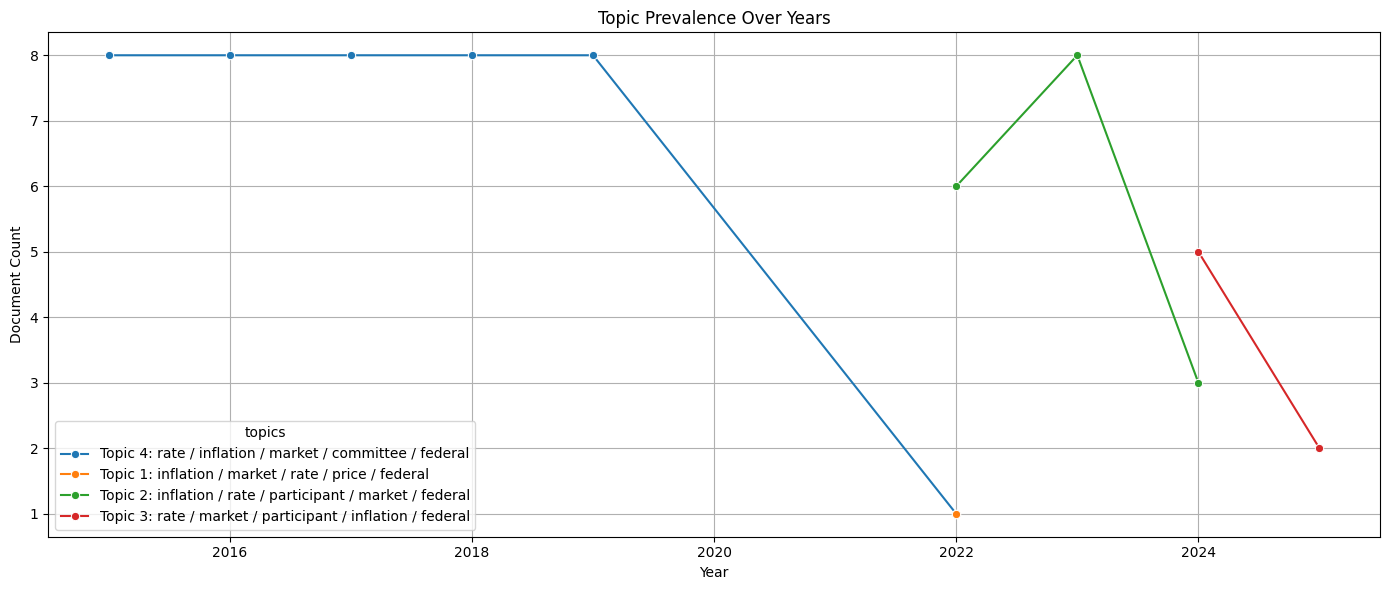

In [ ]:
df_merged['Year'] = pd.to_datetime(df_merged['Date']).dt.year

topic_trend = df_merged.groupby(['Year', 'topics']).size().reset_index(name='Count')

plt.figure(figsize=(14, 6))
sns.lineplot(data=topic_trend, x='Year', y='Count', hue='topics', marker='o')
plt.title("Topic Prevalence Over Years")
plt.xlabel("Year")
plt.ylabel("Document Count")
plt.grid(True)
plt.tight_layout()
plt.show()


Overlay Sentiment with Topics

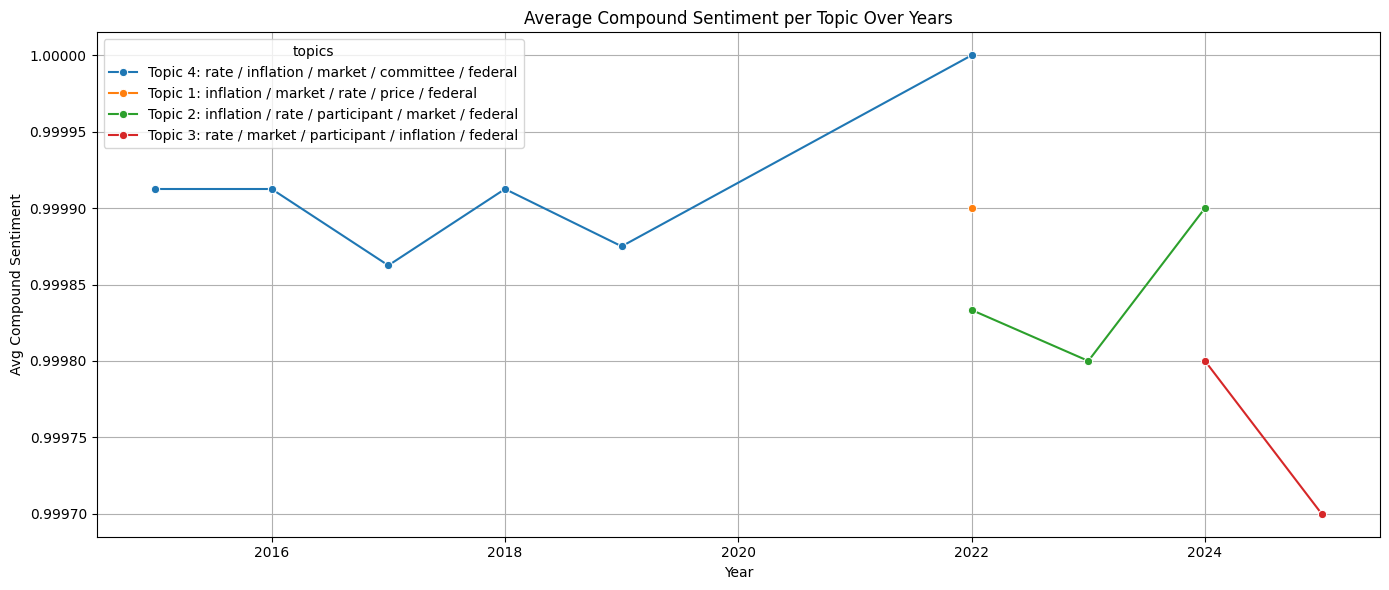

In [ ]:
# Example: Average sentiment per topic per year
sentiment_overlay = df_merged.groupby(['Year', 'topics'])['compound'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=sentiment_overlay, x='Year', y='compound', hue='topics', marker='o')
plt.title("Average Compound Sentiment per Topic Over Years")
plt.ylabel("Avg Compound Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()


Topic–Word Heatmap

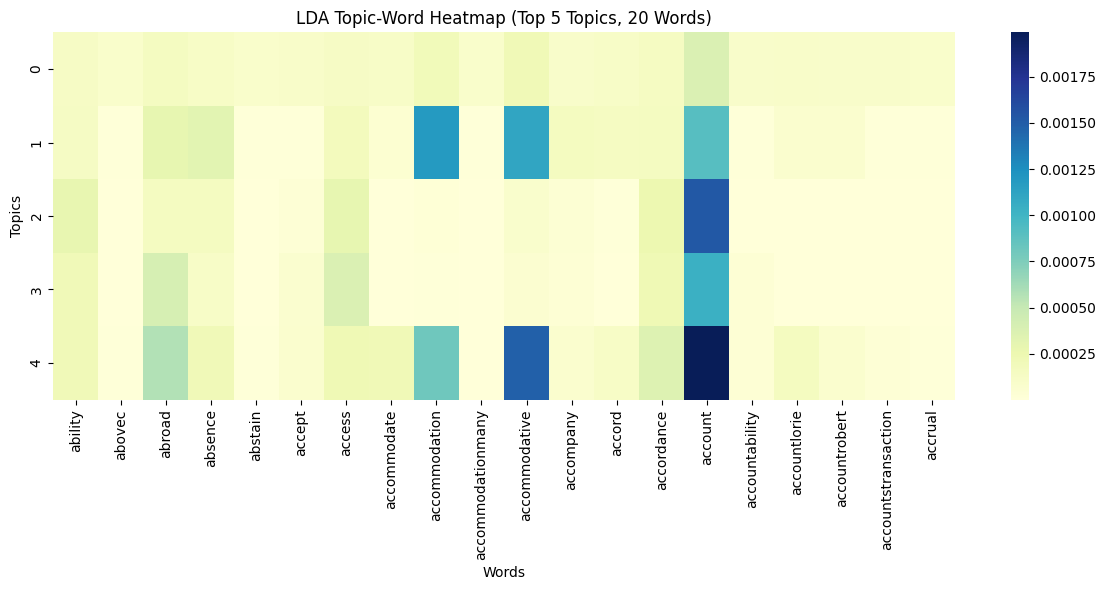

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create matrix of topic-word weights
topic_word_df = pd.DataFrame(lda_model.get_topics(), columns=[dictionary[i] for i in range(len(dictionary))])

plt.figure(figsize=(12, 6))
sns.heatmap(topic_word_df.iloc[:5, :20], cmap='YlGnBu')
plt.title("LDA Topic-Word Heatmap (Top 5 Topics, 20 Words)")
plt.xlabel("Words")
plt.ylabel("Topics")
plt.tight_layout()
plt.show()
